In [1]:
## 导入模型和设置
import os
model_path = 'ckpt-set/ckpt-EDFA2/'
os.system(f'cp {model_path}config.py config.py')
import config
import torch
import numpy as np
import matplotlib.pyplot as plt
import config
from fiber_system import tx,rx,channel_model
from train_model import test_model, get_model
fig_path =  '/Users/xinyu/Desktop/WDM_Code/report/img/expriment/'  # 储存结果的路径

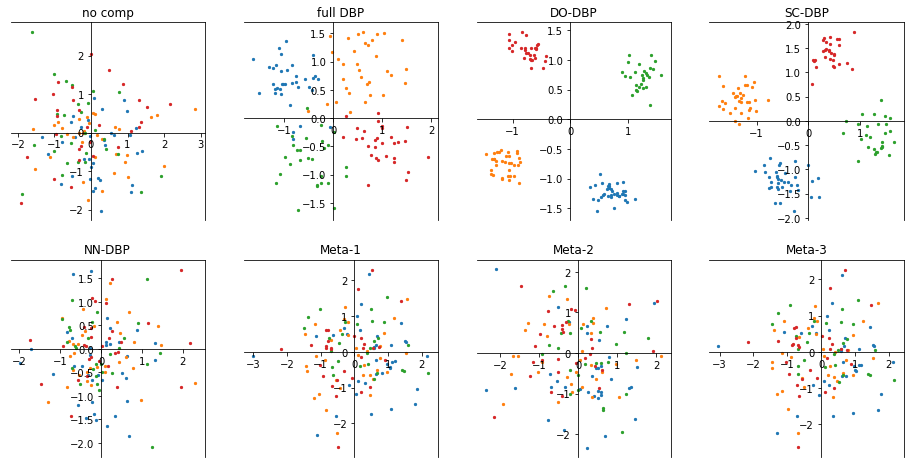

In [2]:

############################ setting parameters ############################
test_power = 1
############################ Initializing the system ############################
k = config.k              # number of central channel
tx.set_power([test_power]*config.Nch)
rx.set_power([test_power]*config.Nch)
comp = {}
z = {}
I = {}

############################ load model     ############################
model_names = ['no comp','full DBP', 'DO-DBP', 'SC-DBP','NN-DBP','Meta-1','Meta-2','Meta-3']

for name in model_names:
    comp[name] = get_model(name, model_path)

############################ simulation and testing    ############################

'''               communication system structure
    ----------------------         -------------          ----------                
x --|      (1)Fiber        |-- y --|  (2)DBP     |-- z --| (3)Filter | --- I --- (4) show constellation
     ----------------------         -------------          ---------
'''

# (1) Fiber
x, symbol_stream, bit_stream = tx.wdm_signal_sample()
y = channel_model(x)

# (2) DBP
for name in model_names:
    if name == 'full DBP':
        z[name] = comp[name](y)[k]
    else:
        z[name] = comp[name](y)[0]


# (3) Filter 
for name in model_names:
    I[name] = rx.filter(z[name], Nch=k)

# (4) show constellation
plt.figure(figsize=(16,8))
for i,name in enumerate(model_names):
    plt.subplot(241+i)
    rx.show_symbol(I[name], symbol_stream[k])
    plt.title(name)
#plt.savefig(fig_path + f'W120-D3-P{power}'+'star.png')

In [8]:
# 计算BER
acc = {}
for name in model_names:
    acc[name] = test_model(channel_model, comp[name], tx,rx,N=100,power=50)

for key in acc.keys():
    print('%10s  &   %g \\\\' % (key, acc[key]))



   no comp  &   0.517852 \\
  full DBP  &   1 \\
    DO-DBP  &   0.332109 \\
    SC-DBP  &   0.405 \\
    NN-DBP  &   0.999453 \\
    Meta-1  &   1 \\
    Meta-2  &   1 \\
    Meta-3  &   0.999961 \\


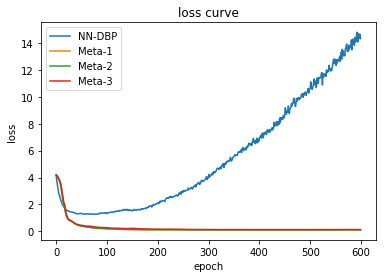

In [4]:
# plot loss curve
loss = {}
power=50
#for name in train_model_names:
train_model_names = ['NN-DBP','Meta-1','Meta-2','Meta-3']
for name in train_model_names:
    loss[name] = torch.load(model_path + name + '_losspath.pt')['train loss']
    plt.plot(loss[name],label=name)

plt.legend(loc='best')
plt.title('loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.savefig(fig_path + f'W120-D3-P{power}'+'loss.png')

In [ ]:
## 待办事项
'''
**1. 可视化参数，看到底是那部分起作用
2. 加宽，加深 网络，或者改变网络架构 （Transformer）
3. 数据增广， 看泛化
4. 学习率策略: 0.001

width: 20,60,100
depth: 2,3,4
power: [50,50], [50,60]
'''

'''
1. meta net 结构调整
(1) complex CNN
(2) complex RNN,Transformer  加入历史信息 S = phi(u_i, u_{i-1})

2.noise term
n  -->  n * u

3. channel num, 16 QAM

'''

In [ ]:
'''
'scale', 'plus', 'scale+plus' 为什么会相同的loss曲线
'''
fiber = Fiber(tx.lam_set,length=1e5,alphaB=0.2,n2=2.7e-20,disp=17,dz=100,Nch=config.Nch,generate_noise=True,noise_level=1e-3)
dsp = Fiber(tx.lam_set,length=1e5,alphaB=-0.2,n2=-2.7e-20,disp=-17,dz=200,Nch=config.Nch)
x,s,_ = tx.wdm_signal_sample()

z = x
for i in range(10):
    y = fiber(z)
    z = dsp(y)
I = rx.filter(z[0],Nch=1)
rx.show_symbol(I,s[0])

In [10]:
a = torch.rand(10,3,100)

In [31]:
torch.index_select(a,dim=-2,index=torch.tensor([0])).shape

torch.Size([10, 1, 100])

tensor([1])